# Figure 4 - damages
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from functools import reduce
import matplotlib.patches as mpatches
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols as reg

Data locations

In [2]:
loc_enso = "../Data/ENSO_Indices/CMIP6/"
loc_damages = "../Data/Damages/"
loc_tc = "../Data/Teleconnections/CMIP6/"

Years

In [3]:
y1 = 2020
y2 = 2099

#### Analysis

read damages

In [4]:
exps = ["ssp126","ssp245","ssp370","ssp585"]

In [5]:
import warnings
warnings.filterwarnings("ignore",category=FutureWarning,message="'base' in .resample")

In [6]:
# level of persistence
persist = "partial"

In [7]:
for e in exps:
    print(e)
    
    enso_models = np.array([m.split("_")[0]+"_"+m.split("_")[1] for m in sorted(os.listdir(loc_enso)) if e in m])
    enso_files = np.array([loc_enso+m for m in sorted(os.listdir(loc_enso)) if e in m])
    enso_ds = xr.open_mfdataset(enso_files,concat_dim="model",combine="nested")
    enso_ds.coords["model"] = enso_models
    alphas = enso_ds.alpha.load()
    alpha_threshold = -0.17 # half the obs value of -0.34
    e_index = enso_ds.e_index.load()
    c_index = enso_ds.c_index.load()
    e_shift = e_index.shift(time=1)
    e_djf = e_shift[:,e_shift.time.dt.month<=3].resample(time="YS").mean(dim="time")
    e_djf.coords["time"] = e_djf.time.dt.year.values
    
    models = np.array([m.split("_")[0]+"_"+m.split("_")[1] for m in sorted(os.listdir(loc_tc)) if (e in m)&("teleconnections_1940" in m)])
    models_files = np.array([loc_tc+m for m in sorted(os.listdir(loc_tc)) if (e in m)&("teleconnections_1940" in m)])
    tc_ds = xr.open_mfdataset(models_files,concat_dim="model",combine="nested")
    tc_ds.coords["model"] = models
    tc_corr = tc_ds.teleconnections_corr_running.sel(index="e").load()
    
    if e=="ssp126":
        damages_e_126 = xr.open_dataset(loc_damages+"CMIP6_Eindex_damages_amplitude_teleconnections_"+e+"_main_"+persist+"persistence_"+str(y1)+"-"+str(y2)+".nc")
        e_126 = e_djf.loc[damages_e_126.model.values,:]
        tc_change_126 = tc_corr.loc[damages_e_126.model.values,"future",:] - tc_corr.loc[damages_e_126.model.values,"hist",:]
        tc_change_126_pct = 100*tc_change_126/tc_corr.loc[damages_e_126.model.values,"hist",:]
    elif e=="ssp245":
        damages_e_245 = xr.open_dataset(loc_damages+"CMIP6_Eindex_damages_amplitude_teleconnections_"+e+"_main_"+persist+"persistence_"+str(y1)+"-"+str(y2)+".nc")
        e_245 = e_djf.loc[damages_e_245.model.values,:]
        tc_change_245 = tc_corr.loc[damages_e_245.model.values,"future",:] - tc_corr.loc[damages_e_245.model.values,"hist",:]
        tc_change_245_pct = 100*tc_change_245/tc_corr.loc[damages_e_245.model.values,"hist",:]
    elif e=="ssp370":
        damages_e_370 = xr.open_dataset(loc_damages+"CMIP6_Eindex_damages_amplitude_teleconnections_"+e+"_main_"+persist+"persistence_"+str(y1)+"-"+str(y2)+".nc")
        e_370 = e_djf.loc[damages_e_370.model.values,:]
        tc_change_370 = tc_corr.loc[damages_e_370.model.values,"future",:] - tc_corr.loc[damages_e_370.model.values,"hist",:]
        tc_change_370_pct = 100*tc_change_370/tc_corr.loc[damages_e_370.model.values,"hist",:]
    elif e=="ssp585":
        damages_e_585 = xr.open_dataset(loc_damages+"CMIP6_Eindex_damages_amplitude_teleconnections_"+e+"_main_"+persist+"persistence_"+str(y1)+"-"+str(y2)+".nc")
        e_585 = e_djf.loc[damages_e_585.model.values,:]
        tc_change_585 = tc_corr.loc[damages_e_585.model.values,"future",:] - tc_corr.loc[damages_e_585.model.values,"hist",:]
        tc_change_585_pct = 100*tc_change_585/tc_corr.loc[damages_e_585.model.values,"hist",:]

ssp126
ssp245
ssp370
ssp585


In [8]:
amp_change_126 = e_126.loc[:,2020:2099].std(dim="time") - e_126.loc[:,1940:2019].std(dim="time")
amp_change_245 = e_245.loc[:,2020:2099].std(dim="time") - e_245.loc[:,1940:2019].std(dim="time")
amp_change_370 = e_370.loc[:,2020:2099].std(dim="time") - e_370.loc[:,1940:2019].std(dim="time")
amp_change_585 = e_585.loc[:,2020:2099].std(dim="time") - e_585.loc[:,1940:2019].std(dim="time")
amp_change_126_pct = 100*amp_change_126/e_126.loc[:,1940:2019].std(dim="time")
amp_change_245_pct = 100*amp_change_245/e_245.loc[:,1940:2019].std(dim="time")
amp_change_370_pct = 100*amp_change_370/e_370.loc[:,1940:2019].std(dim="time")
amp_change_585_pct = 100*amp_change_585/e_585.loc[:,1940:2019].std(dim="time")

In [9]:
y1_e_sum = 2020
y2_e_sum = 2099
e_126_future = e_126.loc[:,y1:y2] #- e_126.loc[:,y1:y2].mean()
e_245_future = e_245.loc[:,y1:y2] #- e_245.loc[:,y1:y2].mean()
e_370_future = e_370.loc[:,y1:y2] #- e_370.loc[:,y1:y2].mean()
e_585_future = e_585.loc[:,y1:y2] #- e_585.loc[:,y1:y2].mean()
e_sum_126 = e_126_future.loc[:,y1_e_sum:y2_e_sum].sum(dim="time")
e_sum_245 = e_245_future.loc[:,y1_e_sum:y2_e_sum].sum(dim="time")
e_sum_370 = e_370_future.loc[:,y1_e_sum:y2_e_sum].sum(dim="time")
e_sum_585 = e_585_future.loc[:,y1_e_sum:y2_e_sum].sum(dim="time")

Discounted damages

In [10]:
rates = np.array([0.01,0.02,0.03,0.05])
time = np.arange(y1,y2+1,1)
dfact = xr.DataArray(np.zeros((len(rates),len(time))),
                     coords=[rates,time],dims=["rate","time"])
for r in rates:
    dfact.loc[r,:] = np.exp(-1*r*(time-np.amin(time)))

In [11]:
damages_e_plot_126 = (damages_e_126.gdp_change_global*dfact).sum(dim="time")/1e12
damages_e_plot_245 = (damages_e_245.gdp_change_global*dfact).sum(dim="time")/1e12
damages_e_plot_370 = (damages_e_370.gdp_change_global*dfact).sum(dim="time")/1e12
damages_e_plot_585 = (damages_e_585.gdp_change_global*dfact).sum(dim="time")/1e12

In [12]:
ssp_gdp_126_sum = (damages_e_126.ssp_gdp*dfact).sum(dim=["iso","time"])/1e12
ssp_gdp_245_sum = (damages_e_245.ssp_gdp*dfact).sum(dim=["iso","time"])/1e12
ssp_gdp_370_sum = (damages_e_370.ssp_gdp*dfact).sum(dim=["iso","time"])/1e12
ssp_gdp_585_sum = (damages_e_585.ssp_gdp*dfact).sum(dim=["iso","time"])/1e12

In [13]:
damages_126_median = damages_e_plot_126.sel(rate=0.02).median(dim=["boot"])
damages_245_median = damages_e_plot_245.sel(rate=0.02).median(dim=["boot"])
damages_370_median = damages_e_plot_370.sel(rate=0.02).median(dim=["boot"])
damages_585_median = damages_e_plot_585.sel(rate=0.02).median(dim=["boot"])

Pool data for regression

In [14]:
e_sum_pooled = np.concatenate([e_sum_126.values,e_sum_245.values,e_sum_370.values,e_sum_585.values])
amp_change_pooled = np.concatenate([amp_change_126.values,amp_change_245.values,amp_change_370.values,amp_change_585.values])
amp_change_pct_pooled = np.concatenate([amp_change_126_pct.values,amp_change_245_pct.values,amp_change_370_pct.values,amp_change_585_pct.values])
damages_pooled = np.concatenate([damages_126_median.values,damages_245_median.values,damages_370_median.values,damages_585_median.values])
tc_change_pooled = np.concatenate([tc_change_126.mean(dim="iso").values,tc_change_245.mean(dim="iso").values,tc_change_370.mean(dim="iso").values,tc_change_585.mean(dim="iso").values])
tc_change_pct_pooled = np.concatenate([tc_change_126_pct.mean(dim="iso").values,tc_change_245_pct.mean(dim="iso").values,tc_change_370_pct.mean(dim="iso").values,tc_change_585_pct.mean(dim="iso").values])

In [15]:
stats.linregress(amp_change_pct_pooled,damages_pooled)

LinregressResult(slope=-4.1153848824711865, intercept=-36.04455872982742, rvalue=-0.5343257372520813, pvalue=4.795605255275095e-19, stderr=0.42289260819409)

In [16]:
stats.linregress(tc_change_pct_pooled,damages_pooled)

LinregressResult(slope=-6.297007323154007, intercept=-22.656320275780516, rvalue=-0.5551038176369545, pvalue=1.0183224194318728e-20, stderr=0.6129073712960853)

In [17]:
df = pd.DataFrame({"damages":damages_pooled,
                  "amp_change":amp_change_pct_pooled,
                  "amp_change2":amp_change_pct_pooled**2,
                  "tc_change":tc_change_pct_pooled,
                  "tc_change2":tc_change_pct_pooled**2,
                  "e_sum":e_sum_pooled,
                  "e_sum_norm":e_sum_pooled-e_sum_pooled.mean(),
                  "e_sum_norm2":e_sum_pooled-e_sum_pooled.mean()})

                            OLS Regression Results                            
Dep. Variable:                damages   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     73.28
Date:                Mon, 08 May 2023   Prob (F-statistic):           7.19e-46
Time:                        11:13:09   Log-Likelihood:                -1344.6
No. Observations:                 239   AIC:                             2701.
Df Residuals:                     233   BIC:                             2722.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.00

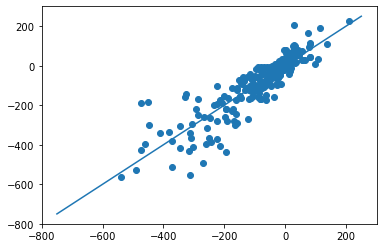

In [18]:
mdl = reg("damages ~ amp_change + tc_change + e_sum_norm + e_sum_norm:amp_change + e_sum_norm:tc_change",data=df).fit(cov_type='HC3')
print(mdl.summary())
predicted = mdl.predict()
plt.scatter(predicted,damages_pooled)
plt.plot([-750,250],[-750,250])

Plot a new version of Fig 4

In [19]:
min_mdl = "MIROC-ES2L_r6i1p1f2"
max_mdl = "CESM2-WACCM_r3i1p1f1"
min_mdl_name = "MIROC-ES2L r6i1p1f2 SSP2-4.5" # (+"+str(np.around(amp_change_245.loc[min_mdl].values,2))+")"
max_mdl_name = "CESM2-WACCM r3i1p1f1 SSP2-4.5" # (+"+str(np.around(amp_change_245.loc[max_mdl].values,2))+")"

In [20]:
np.median(damages_e_plot_245.sel(rate=0.02).values.flatten())

-84.17261846614062

ssp126
-18.99522938628338
-0.2%
-2.1041580593608433
ssp245
-84.17261846614062
-0.9%
-0.9328347686343524
ssp370
-37.376934064166555
-0.5%
-0.28666098836196086
ssp585
-67.84546816444798
-0.4%
-0.644723762194902


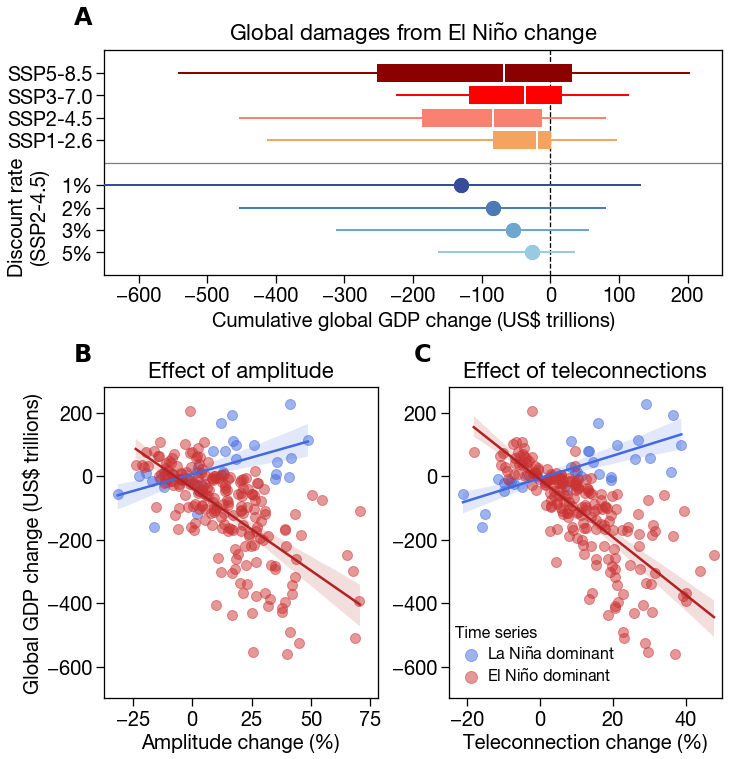

In [21]:
fig = plt.figure(figsize=(11,12))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

tfs = 22
textfs = 16

scen_cols = ["sandybrown","salmon","red","darkred"]
scen_names = ["SSP1-2.6","SSP2-4.5","SSP3-7.0","SSP5-8.5"]

gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.18,right=0.96,top=0.9,bottom=0.64,wspace=0.3,hspace=0.54)

ax = plt.subplot(gs1[0,0])
plt.setp(ax.spines.values(), linewidth=1.3)
overall_xlim = [-650,250]
    
main_drate = 0.02

scenario_pos = [6,7,8,9]
for ee in np.arange(0,len(exps),1):
    e = exps[ee]
    print(e)
    if e=="ssp126":
        damages_box = damages_e_plot_126.sel(rate=main_drate).values.flatten()   
        damages_mdl = damages_e_plot_126.sel(rate=main_drate).mean(dim="boot").values
        gdp_sum = ssp_gdp_126_sum.sel(rate=main_drate)
    if e=="ssp245":
        damages_box = damages_e_plot_245.sel(rate=main_drate).values.flatten()
        damages_mdl = damages_e_plot_245.sel(rate=main_drate).mean(dim="boot").values
        gdp_sum = ssp_gdp_245_sum.sel(rate=main_drate)
    if e=="ssp370":
        damages_box = damages_e_plot_370.sel(rate=main_drate).values.flatten()
        damages_mdl = damages_e_plot_370.sel(rate=main_drate).mean(dim="boot").values
        gdp_sum = ssp_gdp_370_sum.sel(rate=main_drate)
    if e=="ssp585":
        damages_box = damages_e_plot_585.sel(rate=main_drate).values.flatten()
        damages_mdl = damages_e_plot_585.sel(rate=main_drate).mean(dim="boot").values
        gdp_sum = ssp_gdp_585_sum.sel(rate=main_drate)
    
    print(np.nanmedian(damages_box))
    print(str(np.around(100*(np.nanmedian(damages_box)/gdp_sum.values),1))+"%")
    print(stats.skew(damages_box))
    #print(len(damages_box[damages_box<0])/len(damages_box))
    b1 = plt.boxplot(damages_box,sym="",widths=0.7,zorder=2,
                    vert=False,positions=[scenario_pos[ee]],
                        showcaps=False,patch_artist=True,whis=[2.5,97.5])
    for m in range(0,2,1):
        if m == 0:
            b1["boxes"][m].set(color=scen_cols[ee],linewidth=2)
            b1["medians"][m].set(color="white",linewidth=2)
            b1["medians"][m].set(color="white",linewidth=2)
        b1["whiskers"][m].set(color=scen_cols[ee],linewidth=2)
    
    #plt.scatter(damages_mdl,[scenario_pos[ee]]*len(damages_mdl),
    #           zorder=3,edgecolor="black",facecolor=scen_cols[ee],
    #           s=100)

#plt.ylim([-8,10])
plt.xlim(overall_xlim)
plt.xlabel("Cumulative global GDP change (US$ trillions)")
plt.axvline(x=0,linewidth=1.3,color="black",linestyle="--",zorder=1)
plt.title("Global damages from El Ni$\~n$o change",fontsize=22,pad=10)
lbs = ["SSP1-2.6","SSP2-4.5","SSP3-7.0","SSP5-8.5"]
#plt.yticks(ticks=scenario_pos,labels=lbs)
#plt.ylim([0.3,4.7])


## discount rate stuff
plt.axhline(y=5,color="gray",linewidth=1.3,linestyle='-')
#plt.axhline(y=0,color="gray",linewidth=1.3,linestyle='-')

rate_cols = {0.01:[54,75,154],0.02:[74,123,183],
             0.03:[110,166,205],0.05:[152,202,225]}

drate_yvals = [4,3,2,1]
for rr in np.arange(0,len(rates),1):
    yval = drate_yvals[rr]
    col = np.array(rate_cols[rates[rr]])/255. 
    damages_drate = damages_e_plot_245.sel(rate=rates[rr]).values.flatten()
    q75, q25 = np.percentile(damages_drate,[75,25])
    iqr = q75 - q25
    #plt.plot([q25-(1.5*iqr),q75+(1.5*iqr)],[yval,yval],linewidth=2,color=col,zorder=3)
    #print(q25-(1.5*iqr))
    q2_5, q97_5 = np.percentile(damages_drate,[2.5,97.5])
    plt.plot([q2_5,q97_5],[yval,yval],linewidth=2,color=col,zorder=3)
    plt.scatter([np.median(damages_drate),np.median(damages_drate)],
                [yval,yval],s=200,color=col,zorder=3)

plt.ylim([0,10])
tks = [1,2,3,4,6,7,8,9]
lbs = ["5%","3%","2%","1%","SSP1-2.6",\
      "SSP2-4.5","SSP3-7.0","SSP5-8.5"]
plt.yticks(ticks=tks,labels=lbs)
plt.ylabel("Discount rate"+"\n"+"(SSP2-4.5)")
ax.yaxis.set_label_coords(-0.09,0.26)



gs3 = gridspec.GridSpec(1,2)
gs3.update(left=0.18,right=0.96,top=0.51,bottom=0.15,wspace=0.26,hspace=0.54)

for k in [0,1]:
    ax = plt.subplot(gs3[0,k])
    plt.setp(ax.spines.values(), linewidth=1.3)

    if k == 0:
        plt.title("Effect of amplitude",fontsize=tfs,pad=10)
        x = amp_change_pct_pooled
    else:
        plt.title("Effect of teleconnections",fontsize=tfs,pad=10)
        x = tc_change_pct_pooled
        
    y = damages_pooled
    
    
    # e_sum colorbar
    vmin = -16
    vmax = 16
    ncol = 17
    bounds = np.linspace(vmin,vmax,ncol)
    cols = plt.get_cmap('coolwarm')(np.linspace(0,1,len(bounds)+1))
    cm = colors.ListedColormap(cols[1:-1])
    cm.set_over(cols[-1])
    cm.set_under(cols[0])
    norm = colors.Normalize(vmin=vmin,vmax=vmax)
    cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)

    # scatter
    #cols = [cbar.to_rgba(x) for x in e_sum_pooled]
    #plt.scatter(x,y,facecolor=[0.85,0.85,0.85],edgecolor="black",s=100)
    z = e_sum_pooled*1.0
    
    # e sum < 0 
    #,edgecolor="black"
    plt.scatter(x[z<0],y[z<0],facecolor="royalblue",s=100,alpha=0.5,
               label="La Ni${\~n}$a dominant")
    regplt0 = sns.regplot(x[z<0],y[z<0],scatter=False,color="royalblue",
                truncate=True,line_kws={"linestyle":"-","linewidth":2.5})
    #plt.setp(regplt0.collections[1], alpha=0.24)
    
    # e sum > 0 
    plt.scatter(x[z>0],y[z>0],facecolor=[0.8,0.2,0.2],s=100,
               alpha=0.5,label="El Ni${\~n}$o dominant")
    regplt1 = sns.regplot(x[z>0],y[z>0],scatter=False,color="firebrick",
                truncate=True,line_kws={"linestyle":"-","linewidth":2.5})
    #plt.setp(regplt1.collections[1], alpha=0.24)

    beta, intercept, r, p, se = stats.linregress(x,y)
    textsz = 17
    #plt.text(0.05,0.11,r"$\it{\beta}$ = "+str(np.around(beta,1))+" \$T %$^{-1}$",
    #         fontsize=textsz,transform=ax.transAxes)
    #plt.text(0.05,0.05,"$\it{P}$ < 0.001",fontsize=textsz,transform=ax.transAxes)

    if k == 0:
        plt.ylabel("Global GDP change (US$ trillions)")
        plt.xlabel("Amplitude change (%)")
        plt.xlim([-37,78])
        plt.xticks([-25,0,25,50,75])
        #leg = plt.legend(loc="lower right",frameon=True,fontsize=17,
        #                edgecolor="black",handletextpad=0.8,
        #                fancybox=False,framealpha=1,bbox_to_anchor=(1.8,-0.41,0,0))
    if k == 1:
        plt.xlabel("Teleconnection change (%)")
        plt.xlim([-25,50])
        leg = plt.legend(loc="lower left",frameon=False,fontsize=16,
                        handletextpad=0.01,markerscale=1.2,bbox_to_anchor=(-0.03,0,0,0),
                        title = "Time series",labelspacing=0.3)
        plt.setp(leg.get_title(),fontsize=16)
        leg._legend_box.align = "left"
    plt.ylim([-700,280])    
    

plt.figtext(0.14,0.93,r'$\bf{A}$',fontsize=24)
plt.figtext(0.14,0.54,r'$\bf{B}$',fontsize=24)
plt.figtext(0.57,0.54,r'$\bf{C}$',fontsize=24)

plt.savefig("../Figures/Fig4.pdf")
plt.show()

In [22]:
print(np.nanmedian(damages_e_plot_126.sel(rate=0.02).values.flatten()))
print(np.nanmedian(damages_e_plot_245.sel(rate=0.02).values.flatten()))
print(np.nanmedian(damages_e_plot_370.sel(rate=0.02).values.flatten()))
print(np.nanmedian(damages_e_plot_585.sel(rate=0.02).values.flatten()))

-18.99522938628338
-84.17261846614062
-37.376934064166555
-67.84546816444798


In [23]:
print(np.percentile(damages_e_plot_245.sel(rate=0.02).values.flatten(),[2.5,97.5]))
print(np.percentile(damages_e_plot_245.sel(rate=0.01).values.flatten(),[2.5,50,97.5]))
print(np.percentile(damages_e_plot_245.sel(rate=0.05).values.flatten(),[2.5,50,97.5]))
print(100*np.percentile(damages_e_plot_245.sel(rate=0.02).values.flatten(),[2.5,50,97.5])/ssp_gdp_245_sum.sel(rate=0.02).values)
print(100*np.percentile(damages_e_plot_245.sel(rate=0.01).values.flatten(),[2.5,50,97.5])/ssp_gdp_245_sum.sel(rate=0.01).values)

[-452.67913844   80.2205299 ]
[-687.34936313 -130.57577944  129.91514084]
[-162.38045202  -26.28263508   33.90950199]
[-4.71789347 -0.87726032  0.83607103]
[-4.7068179  -0.89415434  0.88963043]
